In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import seaborn as sns
from autoxgb import AutoXGB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

plt.style.use('ggplot')


random_state= 42
np.random.seed(random_state)
random.seed(random_state)
warnings.filterwarnings('ignore')

/home/balde/Downloads/AUR/y/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [4]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [5]:
ss.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 297177 non-null  object 
 1   Datetime           297177 non-null  object 
 2   Sensor1_PM2.5      293563 non-null  float64
 3   Sensor2_PM2.5      293563 non-null  float64
 4   Temperature        293628 non-null  float64
 5   Relative_Humidity  293628 non-null  float64
 6   Offset_fault       297177 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.9+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 127361 non-null  object 
 1   Datetime           127361 non-null  object 
 2   Sensor1_PM2.5      127361 non-null  float64
 3   Sensor2_PM2.5      127361 non-null  float64
 4   Temperature        39271 non-null   float64
 5   Relative_Humidity  39271 non-null   float64
dtypes: float64(4), object(2)
memory usage: 5.8+ MB


<AxesSubplot:>

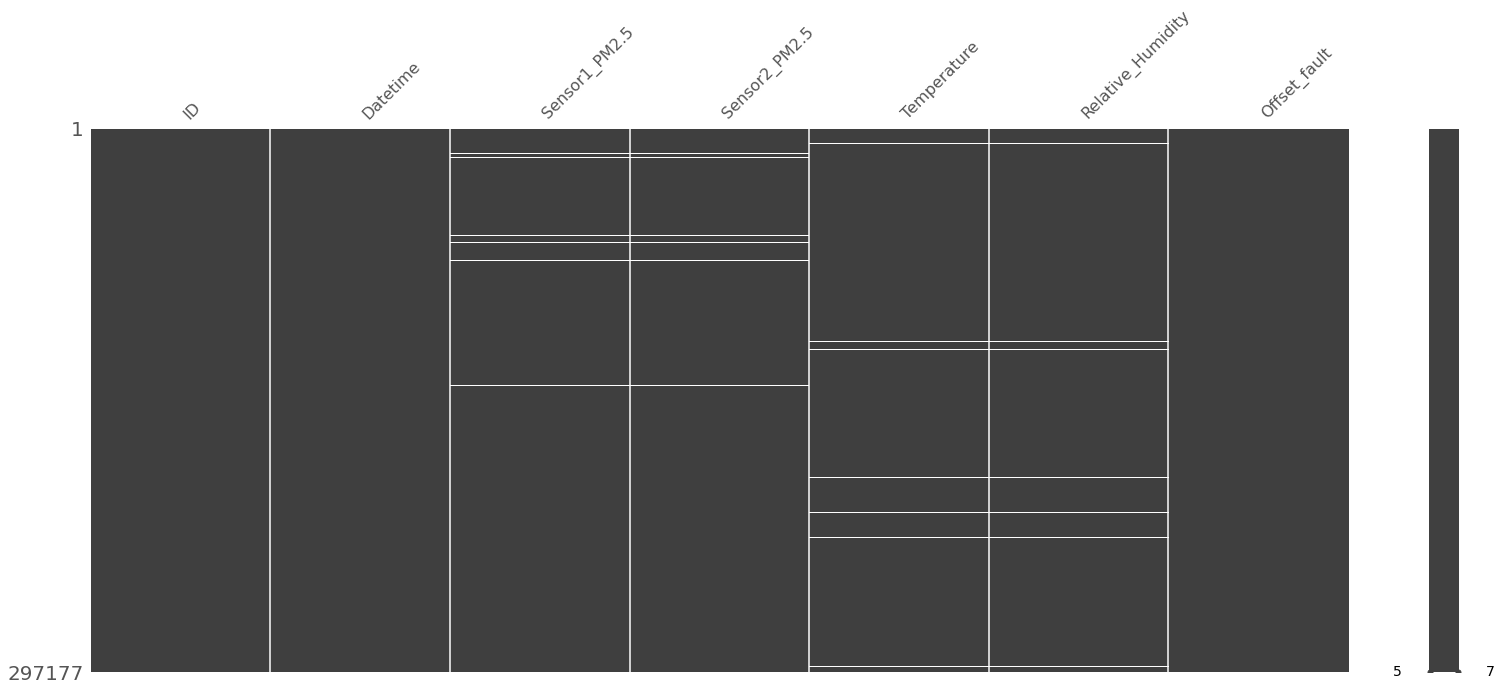

In [8]:
mn.matrix(train)

In [9]:
train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)

In [10]:
train.loc[:, 'Sensor1_PM2.5':'Offset_fault'].describe().T.style.bar(subset=['mean'], color='#206ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Sensor1_PM2.5,293563.000000,40.751195,28.526182,-9.450000,22.430000,36.470000,49.420000,997.960000
Sensor2_PM2.5,293563.000000,38.183018,28.647761,-9.700000,19.520000,33.720000,47.570000,997.260000
Temperature,293628.000000,23.316554,3.836971,16.700000,20.400000,21.900000,26.300000,34.900000
Relative_Humidity,293628.000000,78.653623,14.772725,27.000000,68.000000,84.000000,91.000000,99.000000
Offset_fault,297177.000000,0.371072,0.483092,0.000000,0.000000,0.000000,1.000000,1.000000


<AxesSubplot:xlabel='Offset_fault', ylabel='count'>

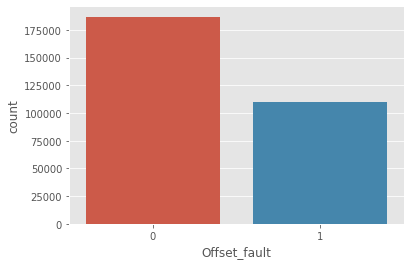

In [11]:
### Now let's visualize 
sns.countplot(train.Offset_fault)

In [12]:
# Extract day, month year and hour from the Datetime column
# day
def converte_dates(df):
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    #
    df['Datetime_day'] = df.Datetime.dt.day

    # month
    df['Datetime_month'] = df.Datetime.dt.month

    # year
    df['Datetime_year'] = df.Datetime.dt.year

    # hour
    df['Datetime_hour'] = df.Datetime.dt.hour
    
    # minute
    df['Datetime_minute'] = df.Datetime.dt.minute
    
    # day of week
    df['Datetime_dayofweek'] = df.Datetime.dt.weekday
    
    
    return df


train = converte_dates(train)
test = converte_dates(test)

In [13]:
def more_features(df):
    df['is_morning'] = (6 <= df['Datetime_hour']) & (df['Datetime_hour'] < 12)#.median()
    df['is_afternoon'] = (12 <= df['Datetime_hour']) & (df['Datetime_hour'] < 18)#.median()
    df['is_evening'] = (18 <= df['Datetime_hour']) & (df['Datetime_hour'] <= 23)#.median()
    df['is_night'] = (0 <= df['Datetime_hour']) & (df['Datetime_hour'] < 6)#.median()
    return df


train = more_features(train)
test = more_features(test)

In [14]:
corr = train.corr()
corr.style.background_gradient()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night
Sensor1_PM2.5,1.000000,0.959253,-0.390342,0.345020,-0.176257,-0.065845,-0.165492,0.161995,-0.058490,-0.000501,0.005246,0.084063,-0.345226,0.159475,0.099684
Sensor2_PM2.5,0.959253,1.000000,-0.363295,0.318470,-0.309739,-0.060088,-0.172149,0.172634,-0.054364,-0.000481,0.000965,0.080507,-0.321080,0.147091,0.091623
Temperature,-0.390342,-0.363295,1.000000,-0.933608,0.005218,-0.012197,0.033259,-0.027746,0.374180,0.000575,0.001721,-0.159391,0.692063,-0.075966,-0.446118
Relative_Humidity,0.345020,0.318470,-0.933608,1.000000,-0.005508,0.054963,0.090350,-0.093323,-0.389953,-0.000132,0.009902,0.202005,-0.660733,0.022660,0.425752
Offset_fault,-0.176257,-0.309739,0.005218,-0.005508,1.000000,0.003973,0.006119,-0.004846,0.004706,0.000194,-0.000755,-0.002761,0.003058,0.003029,-0.003269
Datetime_day,-0.065845,-0.060088,-0.012197,0.054963,0.003973,1.000000,0.269636,-0.313015,-0.003369,0.000952,0.038032,-0.001047,-0.003515,-0.000148,0.004652
Datetime_month,-0.165492,-0.172149,0.033259,0.090350,0.006119,0.269636,1.000000,-0.986940,0.006486,0.000115,0.016727,-0.004147,-0.002766,0.009331,-0.002366
Datetime_year,0.161995,0.172634,-0.027746,-0.093323,-0.004846,-0.313015,-0.986940,1.000000,-0.008027,-0.000183,-0.024027,0.004720,0.002631,-0.010660,0.003243
Datetime_hour,-0.058490,-0.054364,0.374180,-0.389953,0.004706,-0.003369,0.006486,-0.008027,1.000000,0.000474,0.003859,-0.242939,0.256325,0.750688,-0.752726
Datetime_minute,-0.000501,-0.000481,0.000575,-0.000132,0.000194,0.000952,0.000115,-0.000183,0.000474,1.000000,0.000479,-0.002075,0.000808,0.000538,0.000728


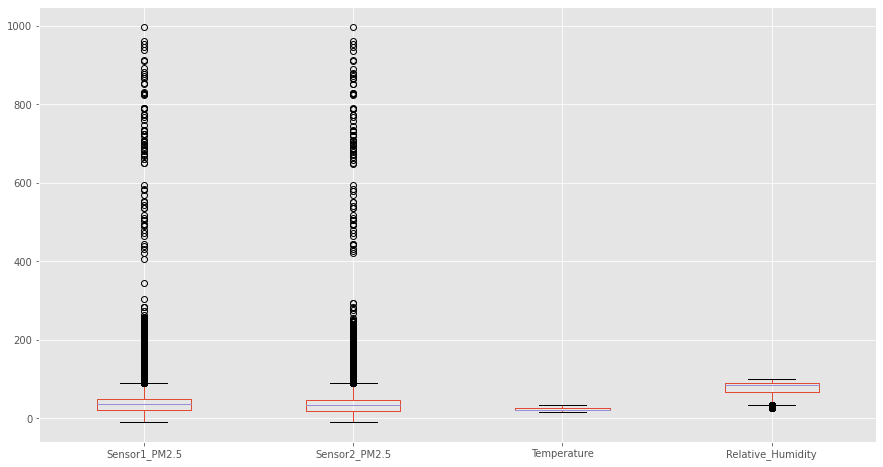

In [15]:
plt.rcParams['figure.figsize']=(15,8)
train.boxplot(column=['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity'])
plt.show()

In [16]:
train.shape,test.shape

((297177, 16), (127361, 15))

In [17]:
train = train.drop('Datetime',axis=1)
test = test.drop('Datetime',axis=1)

In [18]:
train.shape

(297177, 15)

In [19]:
X = train.drop('Offset_fault',axis=1)
y = train['Offset_fault']

X_test = test.copy



Here I am capturing NaN per row and making new feature


In [20]:
def feature_engineering(df):
    df['NaN_row'] = df.isna().sum(axis=1)
    df['std'] = df.std(axis=1)
    return df

X = feature_engineering(X)
test = feature_engineering(test)

# added code

In [21]:
def feature_engineering(df):
    df['AverageTemperature'] = df['Temperature'].mean(axis=0)
    df['Relative_Humidity'] = df['Relative_Humidity'].mean(axis=0)
    df['Total_sensor'] = df['Sensor1_PM2.5'] + df['Sensor2_PM2.5']
    
    return df

X = feature_engineering(X)
test = feature_engineering(test)

X.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night,NaN_row,std,AverageTemperature,Total_sensor
0,52.58,49.52,17.4,78.653623,3,11,2021,4,6,2,False,False,False,True,0,518.087244,23.316554,102.10
1,35.25,33.40,25.0,78.653623,8,11,2021,18,43,0,False,False,True,False,0,517.665411,23.316554,68.65
2,19.18,23.50,24.9,78.653623,7,11,2021,9,50,6,True,False,False,False,0,518.074715,23.316554,42.68
3,19.40,15.48,24.9,78.653623,1,1,2022,18,55,5,False,False,True,False,0,518.627532,23.316554,34.88
4,38.30,34.77,20.9,78.653623,5,11,2021,22,23,4,False,False,True,False,0,517.765326,23.316554,73.07


# Outlier removal

In [22]:
X.shape

(297177, 18)

### Pipeline for data transformation 

In [23]:
pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
test = pd.DataFrame(columns=test.columns, data=pipeline.transform(test))

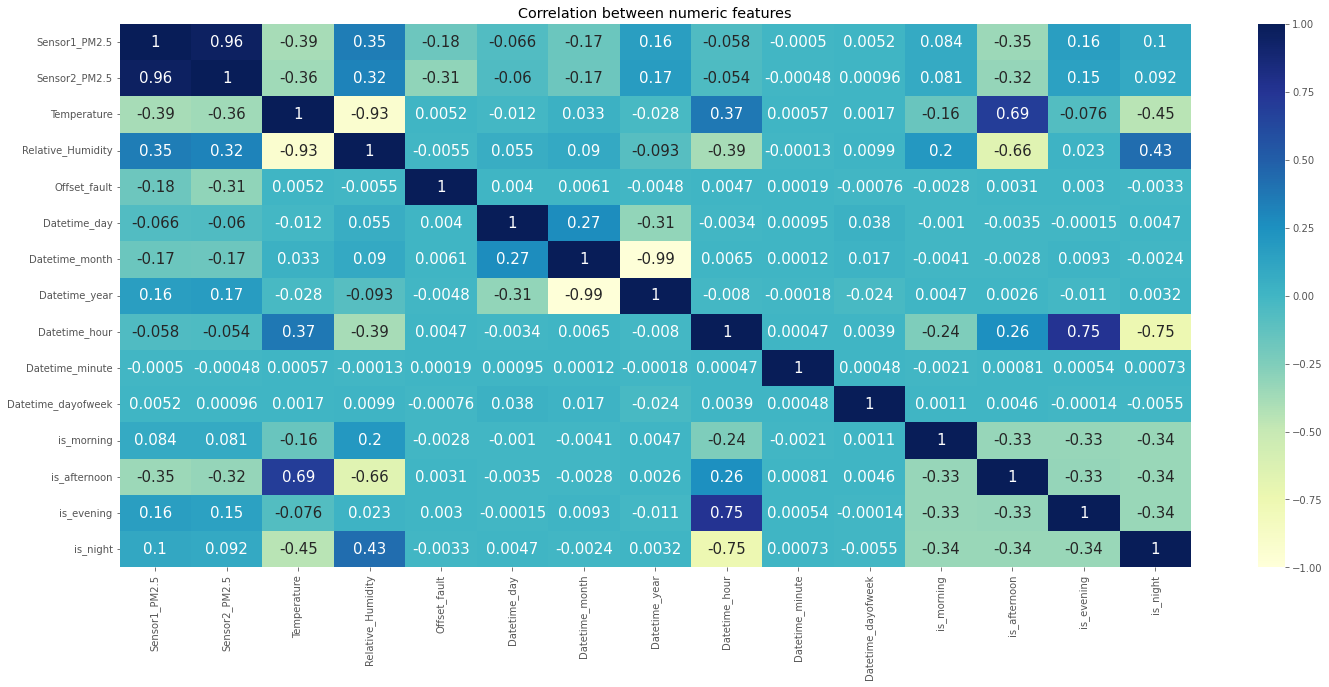

In [24]:
plt.figure(figsize=(24,10))
sns.heatmap(train.corr(), cmap='YlGnBu', vmax=1.0, vmin=-1.0, annot = True, annot_kws={"size": 15})
plt.title('Correlation between numeric features')
plt.show()

In [25]:
X.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night,NaN_row,std,AverageTemperature,Total_sensor
0,0.417210,0.398166,-1.551279,5.684342e-14,-1.499409,0.460813,-0.512278,-1.064973,-1.356771,-0.494456,-0.577240,-0.572272,-0.572018,1.701051,-0.157159,-0.116191,-1.421085e-14,0.411885
1,-0.194031,-0.167984,0.441388,5.684342e-14,-0.922426,0.460813,-0.512278,0.951293,0.780438,-1.493974,-0.577240,-0.572272,1.748197,-0.587872,-0.157159,-0.184993,-1.421085e-14,-0.182852
2,-0.760831,-0.515682,0.415169,5.684342e-14,-1.037823,0.460813,-0.512278,-0.344878,1.184775,1.504579,1.732381,-0.572272,-0.572018,-0.587872,-0.157159,-0.118234,-1.421085e-14,-0.644596
3,-0.753072,-0.797353,0.415169,5.684342e-14,-1.730202,-1.926572,1.952065,0.951293,1.473587,1.004820,-0.577240,-0.572272,1.748197,-0.587872,-0.157159,-0.028069,-1.421085e-14,-0.783279
4,-0.086455,-0.119869,-0.633603,5.684342e-14,-1.268616,0.460813,-0.512278,1.527369,-0.374810,0.505061,-0.577240,-0.572272,1.748197,-0.587872,-0.157159,-0.168696,-1.421085e-14,-0.104265


In [26]:
test.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek,is_morning,is_afternoon,is_evening,is_night,NaN_row,std,AverageTemperature,Total_sensor
0,1.763493,2.690163,-2.927525e-01,-6.437789,1.385504,-1.926572,1.952065,-0.488897,1.127013,0.505061,1.732381,-0.572272,-0.572018,-0.587872,-0.157159,-0.386081,0.367284,2.250860
1,0.538894,0.491588,-9.314965e-16,-6.437789,0.000746,-1.687833,1.952065,1.383350,0.029527,-0.494456,-0.577240,-0.572272,1.748197,-0.587872,6.363001,6.221225,0.367284,0.520520
2,12.224781,10.836481,1.254186e+00,-6.437789,0.923918,-1.926572,1.952065,0.807274,1.589112,-1.493974,-0.577240,1.747422,-0.572018,-0.587872,-0.157159,0.228962,0.367284,11.648424
3,0.790727,1.603870,-4.500683e-01,-6.437789,1.731694,-1.926572,1.952065,-0.632916,-1.299009,-1.493974,1.732381,-0.572272,-0.572018,-0.587872,-0.157159,-0.214671,0.367284,1.210558
4,1.004467,0.522846,-1.616560e-01,-6.437789,1.731694,-1.926572,1.952065,-1.641050,0.433864,-1.493974,-0.577240,-0.572272,-0.572018,1.701051,-0.157159,-0.232756,0.367284,0.771039


In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state= 42, test_size=0.002)

# using XGBoost

In [28]:
xgb = XGBClassifier(learning_rate=0.1,class_weight='balanced',
    boosting_type ='gbdt',importance_type='gain',)
xgb.fit(X_train,y_train)
pred_x = xgb.predict(X_test)

accuracy_score(y_test, pred_x)

[02:05:11] WARNING: ../src/learner.cc:576: 
Parameters: { "boosting_type", "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:05:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.957983193277311

In [29]:
pred_xgb = xgb.predict(test)

sub = pd.DataFrame({'ID':ss.ID,'Offset_fault':pred_xgb})
sub.to_csv('xgb.csv',index=False)

In [30]:
# # lgb_params = {
#     "objective" : "binary",
#     # 'n_estimators':500,
#     "metric" : "accuracy",
#     "boosting": 'gbdt',
#     # #"max_depth" : -1,
#     # "num_leaves" : 13,
#     # "learning_rate" : 0.01,
#     # "bagging_freq": 5,
#     # "bagging_fraction" : 0.4,
#     # "feature_fraction" : 0.05,
#     # "min_data_in_leaf": 80,
#     # "min_sum_heassian_in_leaf": 10,
#     # "tree_learner": "serial",
#     # "boost_from_average": "false",
#     #"lambda_l1" : 5,
#     #"lambda_l2" : 5,
#     "bagging_seed" : random_state,
#     "verbosity" : 1,
#     "seed": random_state
# }


lgb = LGBMClassifier(
    objective='binary',learning_rate=0.1,class_weight='balanced',
    boosting_type ='gbdt',importance_type='gain',
    
)
                    
lgb.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', importance_type='gain',
               objective='binary')

In [31]:
y_pred = lgb.predict(X_test)

In [32]:
accuracy_score(y_test,y_pred)

0.9478991596638655

In [33]:
print(f"Training Accuracy: {lgb.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {lgb.score(X_test, y_test):0.3f}")

Training Accuracy: 0.945
Test Accuracy: 0.948


In [34]:
pred_lgb = lgb.predict(test)
sub = pd.DataFrame({'ID':ss.ID,'Offset_fault':pred_lgb})
sub.to_csv('model_lgb.csv',index=False)

In [35]:
lgb = LGBMClassifier()
lgb.fit(X_train.values, y_train)
y_pred = lgb.predict(X_test)
print(f'Accuracy score on the X_test is: {accuracy_score(y_test, y_pred)}')

Accuracy score on the X_test is: 0.9563025210084034


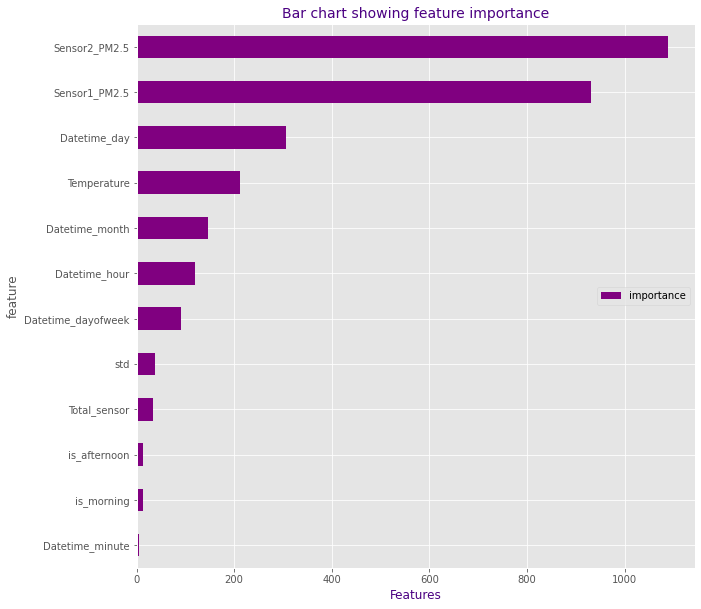

In [36]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': lgb.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [37]:
X.columns.to_list()

['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity',
 'Datetime_day',
 'Datetime_month',
 'Datetime_year',
 'Datetime_hour',
 'Datetime_minute',
 'Datetime_dayofweek',
 'is_morning',
 'is_afternoon',
 'is_evening',
 'is_night',
 'NaN_row',
 'std',
 'AverageTemperature',
 'Total_sensor']

In [38]:
test_df = test.drop(['Datetime_minute','Relative_Humidity',],axis=1)

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X.drop(['Datetime_minute','Relative_Humidity',],axis=1), y, random_state=random_state, test_size=0.01)

In [40]:
lgb = LGBMClassifier(objective='binary',learning_rate=0.1,class_weight='balanced',
    boosting_type ='goss',importance_type='gain',)
lgb.fit(X_train.values, y_train)
y_pred = lgb.predict(X_test)
print(f'Accuracy score on the X_test is: {accuracy_score(y_test, y_pred)}')

Accuracy score on the X_test is: 0.9434724091520862


In [41]:
pred_lgb = lgb.predict(test_df)
sub = pd.DataFrame({'ID':ss.ID,'Offset_fault':pred_lgb})
sub.to_csv('lgb_with_FI.csv',index=False)

# trying other things